## Introduction and Explanation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import itertools
from scipy.stats import ks_2samp

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, recall_score, precision_score, confusion_matrix

from utils import outlier_cut, feature_importance_analysis, plot_learning_curve, linear_regression_imputation, \
binary_kde_plot, simple_modeling, gridSearch, plot_confusion_matrix

random_state = 4

Using TensorFlow backend.


In this project, I put all self-defined funtions into utils.py to make the notebook more clear. I always import these self-defined funtions and invoke these functions in the same cell, to distinguish from functions from third-party libraries.

The whole program will take a while to run, especially the hyperparameter tunning part. 

## Acquire Data

In [2]:
# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
DATA_PATH = "./data"

train_data = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv"), index_col = 0)
test_data = pd.read_csv( os.path.join(DATA_PATH, "test.csv"), index_col = 0)

# Add a 'Bamkrupt' columns in test dataset thus the columns in train and test dataset are same.
test_data = pd.concat([test_data, pd.DataFrame(columns=['Bankrupt'])])

In [3]:
# Have a look
train_data.head()
train_data.describe()
columns_name = train_data.columns

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
311,0.24181,0.22257,0.69576,4.1391,291.09,0,0.30179,3.493,1.0903,0.77743,...,0.303190,0.31103,0.72340,0,11.346,1.4722,74.199,4.9192,13.199,0
592,0.22238,0.49951,0.18799,2.0738,34.422,0.67774,0.27241,0.95653,1.3843,0.47779,...,0.277610,0.46544,0.72239,0.67903,11.762,6.6669,58.208,6.2706,1.7235,0
2051,0.18159,0,1,?,41.034,-0.50524,0.18159,?,5.2157,1,...,0.020505,0.18159,0.96588,0,12.467,9.2532,0.000,?,?,0
3230,0.030523,0.25841,0.053955,1.3421,2.9713,0.085922,0.045425,2.3036,1.0247,0.59528,...,0.024082,0.051274,0.97592,0.16918,22.864,9.3064,54.945,6.643,1.3289,0
3377,0.005688,0.48642,-0.11828,0.75677,-53.123,-0.13066,0.005688,1.0558,2.2043,0.51358,...,0.135840,0.011075,0.88498,0,14.034,10.87,80.521,4.533,3.4878,0


,X13,X19,X20,X23,X30,X31,X39,X42,X43,X44,X49,X55,X56,X58,X62,Bankrupt
count,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4.076000e+03,4076.000000,4076.000000,4076.000000,4076.000000
mean,-0.137813,-0.188458,55.768552,-0.195652,1.015776,-0.156972,0.008625,-0.040268,163.496310,107.727732,-0.091087,1.205361e+04,0.050647,0.962425,302.841224,0.100589
std,8.128243,8.145434,170.304587,8.121939,22.591847,7.967406,0.845687,2.569216,916.546103,850.485257,2.614849,6.733112e+04,0.824277,0.956931,7489.866779,0.300820
min,-310.340000,-310.800000,-29.340000,-310.890000,-16.110000,-310.800000,-47.047000,-143.520000,-3975.600000,-3946.200000,-144.800000,-2.955400e+05,-46.788000,-0.164390,-236.530000,0.000000
25%,0.022647,0.003348,18.483000,0.002252,0.085003,0.005956,0.003954,0.000000,76.711500,38.567500,-0.026733,6.057800e+01,0.010691,0.874343,45.467500,0.000000
50%,0.066518,0.034818,39.034500,0.029865,0.232300,0.042410,0.040087,0.039344,108.840000,59.435000,0.011020,1.798400e+03,0.053946,0.950110,75.472500,0.000000
75%,0.135997,0.088498,67.678000,0.075727,0.413010,0.099240,0.090974,0.089547,149.677500,85.652750,0.059840,8.134975e+03,0.127420,0.990855,120.947500,0.000000
max,78.190000,77.244000,9928.500000,77.244000,1236.700000,77.244000,2.901100,18.088000,40515.000000,40515.000000,16.866000,1.634200e+06,1.651000,47.788000,451380.000000,1.000000


There are many '?' in the data, which refers to missing values. Thus we have to handle missing value first. According to descriptive statistics, therea are also some extreme values, which requires outlier handling.

Actually, at first, I view 'Id' as a feature and the model get really great performance and 'Id' has great importance from feature importance analysis which is based on RandomForestClassifier. But when I dive further, I find, 'Id' labels bankrupt company from 5500 to the end and non-bankrupt company from 0-5549. Obviously, this 'Id' is generated from target, 'Bankrupt'. However, in practice, we are not allowed to get a such 'Id' when we need to predict whether the company will go broke. So I drop it from features.

Text(0.5, 1.0, 'Target variable count')

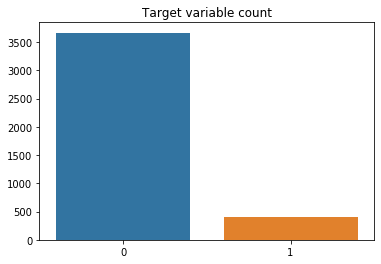

In [4]:
# Show the number of trainning samples in 2 classes of the target 
sns.barplot([0,1],train_data['Bankrupt'].value_counts().values)
plt.title('Target variable count')

Barplot char shows there is a great imbalance between two classes of target, which may influence the learning ability of some models. So after data cleaning, I will try to address this issue at first. And then I will start exploratory data analysis to see the distributions and correlations of features, which will be used in model fitting. 

## Data Cleaning

### Missing Value

In [5]:
# Replace '?' with np.nan, which will be more convenient for following analysis and feature engineering
train_data[train_data == '?'] = np.nan
test_data[test_data == '?'] = np.nan

In [6]:
# Look at data informations
train_data.info()
print('_'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4076 entries, 311 to 5909
Data columns (total 65 columns):
X1          4072 non-null object
X2          4072 non-null object
X3          4072 non-null object
X4          4058 non-null object
X5          4069 non-null object
X6          4072 non-null object
X7          4072 non-null object
X8          4059 non-null object
X9          4075 non-null object
X10         4072 non-null object
X11         4072 non-null object
X12         4058 non-null object
X13         4076 non-null float64
X14         4072 non-null object
X15         4069 non-null object
X16         4059 non-null object
X17         4059 non-null object
X18         4072 non-null object
X19         4076 non-null float64
X20         4076 non-null float64
X21         3973 non-null object
X22         4072 non-null object
X23         4076 non-null float64
X24         3990 non-null object
X25         4072 non-null object
X26         4059 non-null object
X27         3773 non-null obj

There are 4076 entries in the train data set, however, there are many features with 4072 non-null values. In other words, there might be several samples with quite few non-null values. And there is no such samples with many missing values in test dataset. So I decide to drop the samples with a large number of missing values in the training dataset.

In [7]:
# Count the number of missing values in each sample and sort train_data by the number of missing values
train_data['nanNum'] = train_data.isnull().sum(axis=1)
train_data.sort_values(by='nanNum',ascending = False).head(20)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,nanNum
Id,,,,,,,,,,,,,,,,,,,,,
4884,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.022000,NaN,NaN,NaN,0.0000,NaN,NaN,0,41
1783,NaN,NaN,NaN,NaN,3825.1,NaN,NaN,NaN,0.83894,NaN,...,0,1.192000,0,0.46523,0.15025,0.0000,NaN,3.7643,0,32
1783,NaN,NaN,NaN,NaN,3825.1,NaN,NaN,NaN,0.83894,NaN,...,0,1.192000,0,0.46523,0.15025,0.0000,NaN,3.7643,0,32
5880,NaN,NaN,NaN,0,-1076400,NaN,NaN,0,7.2533,NaN,...,NaN,0.137870,NaN,4.8356,NaN,25077.0000,0.014555,NaN,1,28
2059,0.79823,0,1,NaN,126.55,-1.0582,0.90137,NaN,3.7459,1,...,0.79823,0.759390,0,NaN,16.293,0.0000,NaN,NaN,0,20
5583,0.7983,0,1,NaN,126.54,-1.0581,0.90144,NaN,3.7459,1,...,0.7983,0.759380,0,NaN,16.288,0.0000,NaN,NaN,1,20
5844,5.53,0,1,NaN,24.725,-4.532,5.53,NaN,-3.496,1,...,5.53,0.695050,0,NaN,NaN,0.0000,NaN,NaN,1,20
2051,0.18159,0,1,NaN,41.034,-0.50524,0.18159,NaN,5.2157,1,...,0.18159,0.965880,0,12.467,9.2532,0.0000,NaN,NaN,0,17
2051,0.18159,0,1,NaN,41.034,-0.50524,0.18159,NaN,5.2157,1,...,0.18159,0.965880,0,12.467,9.2532,0.0000,NaN,NaN,0,17


In [8]:
# Drop the first 4 samples with the most missing values
train_data = train_data.drop(index = [4884,1783,5880]).sort_values(by='nanNum', ascending = False)
train_data = train_data.drop('nanNum',axis = 1)

In [9]:
# Features with missing value in train and test dataset
train_data.columns.values[train_data.isnull().any()]
test_data.columns.values[test_data.isnull().any()]

array(['X4', 'X5', 'X8', 'X12', 'X15', 'X16', 'X17', 'X21', 'X24', 'X26',
       'X27', 'X28', 'X32', 'X33', 'X34', 'X37', 'X40', 'X41', 'X45',
       'X46', 'X47', 'X50', 'X52', 'X53', 'X54', 'X60', 'X61', 'X63',
       'X64'], dtype=object)

array(['Bankrupt', 'X1', 'X10', 'X11', 'X12', 'X14', 'X15', 'X16', 'X17',
       'X18', 'X2', 'X21', 'X22', 'X24', 'X25', 'X26', 'X27', 'X28',
       'X29', 'X3', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X4',
       'X40', 'X41', 'X45', 'X46', 'X47', 'X48', 'X5', 'X50', 'X51',
       'X52', 'X53', 'X54', 'X57', 'X59', 'X6', 'X60', 'X61', 'X63',
       'X64', 'X7', 'X8'], dtype=object)

In [10]:
# Count the number of missing values in each feature
train_data.isnull().sum(axis=0).sort_values(ascending=False).head(20)
test_data.isnull().sum(axis=0).sort_values(ascending=False).head(20)

X37    1771
X27     302
X60     197
X45     197
X21     102
X24      82
X64      64
X54      64
X53      64
X28      64
X41      54
X32      29
X47      23
X52      23
X40      15
X12      15
X46      15
X33      15
X63      15
X4       15
dtype: int64

Bankrupt    1000
X37          464
X27          149
X21          100
X45           61
X60           61
X28           30
X53           30
X54           30
X64           30
X24           13
X41           10
X32            6
X34            4
X4             4
X26            4
X46            4
X47            4
X8             4
X12            4
dtype: int64

In [11]:
#Fill missing values of 28 features with the median value in training set
feature_set = set(test_data.columns.values[test_data.isnull().any()]) \
                .union(set(train_data.columns.values[train_data.isnull().any()]))-set(['X37'])
for i in feature_set:
    train_data[i] = train_data[i].fillna(train_data[i].median())
    test_data[i] = test_data[i].fillna(train_data[i].median())

In [12]:
from utils import linear_regression_imputation
# Use linear regression to predict the missing value of X37
train_data, test_data = linear_regression_imputation(train_data, test_data, ['X37'], ['Bankrupt'])

There are 52 features with missing values either in train_data or in test_data. And both in train_data and test_data, only Feature X37 have a large number of missing values. Here I fill missing values of 51 features with the median value in the training set. And for Feature X37, I take other features (except target) as parameters and use linear regression to predict the missing value. 

In [13]:
# Convert data to float type, which will be helpful for feature engineering and modeling
train_data = train_data.astype('float64')
test_data = test_data.astype('float64')

### Outlier

In [14]:
train_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,...,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000
mean,-0.090921,0.572122,0.167285,4.290540,-2.606950,-0.179277,-0.077876,5.675165,1.602734,0.478513,...,0.050682,-0.317448,0.962500,0.198375,43.064913,10.672030,296.980312,8.161193,74.052514,0.100442
std,7.300230,1.548964,1.455324,26.921384,1574.442975,8.468069,7.300937,66.592669,1.581206,4.466761,...,0.824641,20.882938,0.957300,4.896995,380.693775,35.975794,7483.472354,32.127403,2533.230512,0.300625
min,-463.890000,0.000000,-72.067000,-0.403110,-41656.000000,-463.890000,-463.890000,-0.986570,-3.496000,-71.444000,...,-46.788000,-1236.300000,-0.164390,-184.980000,-12.440000,-0.092493,-236.530000,-1.543200,-3.726500,0.000000
25%,0.003305,0.253030,0.037480,1.080900,-46.637250,0.000000,0.004533,0.470075,1.014275,0.312893,...,0.010808,0.015543,0.874343,0.000000,5.393175,4.261000,45.635000,3.016500,2.189375,0.000000
50%,0.047585,0.455255,0.218810,1.640100,-0.007903,0.000000,0.057278,1.135500,1.141650,0.520855,...,0.053946,0.112030,0.950110,0.004210,8.854800,6.132300,75.490000,4.821300,4.020100,0.000000
75%,0.117060,0.668790,0.420215,2.981100,48.963000,0.100030,0.136438,2.841650,1.805500,0.722725,...,0.127420,0.239797,0.990670,0.201242,15.994500,9.426525,120.947500,7.906750,9.343425,0.000000
max,5.530000,72.416000,28.336000,788.090000,34259.000000,203.150000,5.530000,2922.000000,37.807000,266.860000,...,1.651000,87.981000,47.788000,83.095000,17739.000000,1266.800000,451380.000000,1526.800000,158180.000000,1.000000


In [15]:
from utils import outlier_cut
# Replace outlier (> quantile(0.995)) with quantile(0.995)
features = set(train_data.columns.values) - set(['Bankrupt'])
train_data = outlier_cut(train_data,features, 0.005)

According to descriptive statistic analysis, many features have positively skewed distribution and probably have some extremely large values. In this case, I replace all outlier or extremely large values with 0.995 quantile value to avoid the negative influence on modeling.

## Resampling

In [16]:
features = set(train_data.columns.values) - set(['Bankrupt'])
X_train = train_data[features]
Y_train = train_data['Bankrupt']

In [17]:
model = SMOTEENN(random_state=0)
X_resampled, Y_resampled = model.fit_sample(X_train, Y_train)
train_data = pd.DataFrame(X_resampled, columns = features)
train_data['Bankrupt'] = Y_resampled
train_data.shape

(5575, 65)

I use SMOTEENN method to address the imbalance problem. In SMOTE method, for any sample A in a minority category, randomly choose a neighbor B, then find a new point on the line of AB as new sample in the category. However, generated new samples near boundary are likely to be noise. Therefore, we can clean the data using under-sampling methods such as EditedNearestNeighbours. In a word, SMOTEENN is a combination of SMOTE and EditedNearestNeighbours.

## Exploratory Data Analysis

In [18]:
train_data = train_data.reindex_axis(columns_name, axis=1)
train_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,...,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000
mean,-0.266971,0.709514,-0.082073,2.619922,-94.854848,-0.462692,-0.257804,2.833073,1.673276,0.131556,...,-0.040852,-3.476442,1.000022,0.264934,31.426881,10.634342,165.436777,6.143609,20.137916,0.548700
std,7.229812,0.657681,2.280237,5.593318,1091.572128,7.532648,7.230665,10.703117,1.277912,2.612756,...,0.564623,51.822697,0.253723,2.762722,123.741547,14.106006,213.295281,8.405196,71.449297,0.497667
min,-463.890000,0.000000,-72.067000,-0.403110,-41656.000000,-463.890000,-463.890000,-0.986570,-3.496000,-71.444000,...,-13.337000,-1236.300000,-0.164390,-107.920000,-12.440000,-0.092493,-236.530000,-1.543200,-3.726500,0.000000
25%,-0.142972,0.342580,-0.132962,0.796169,-84.664733,-0.159510,-0.145121,0.229290,1.003711,0.154172,...,-0.068298,-0.107401,0.904220,0.000000,5.525200,4.680100,55.109500,2.326475,2.351497,0.000000
50%,0.013190,0.586490,0.119146,1.295800,-22.047000,0.000000,0.016383,0.729160,1.210900,0.395316,...,0.028003,0.090131,0.973000,0.011399,9.169600,7.059331,96.850000,3.983700,4.256450,1.000000
75%,0.088781,0.820756,0.353283,2.387272,30.688000,0.007470,0.103100,1.919850,1.951939,0.634924,...,0.095261,0.253522,1.059350,0.235995,18.856926,11.184786,171.630861,6.866257,10.319511,1.000000
max,0.612546,4.803306,0.947410,58.467595,1451.100000,0.999654,0.753945,132.914850,8.945500,0.996255,...,1.000000,5.427810,2.204904,12.207880,1737.027500,152.163700,1357.762000,81.170880,988.830000,1.000000


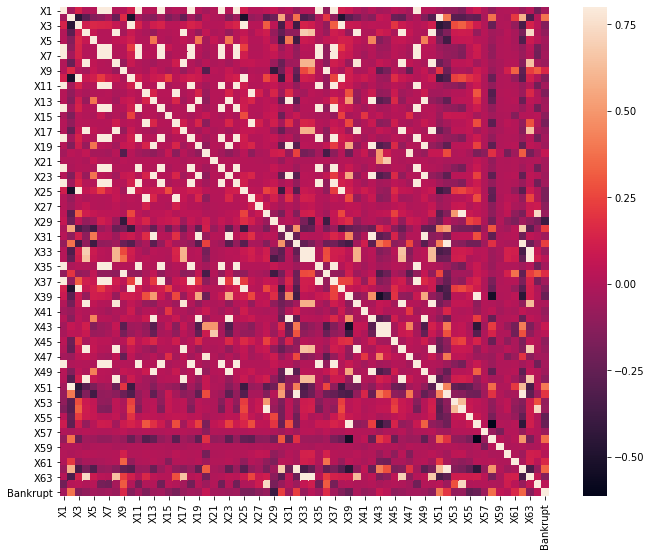

In [19]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

From the correlation heatmap, some features show quite high correlation with each. While for Bankrupt, since it's a binary variable, Pearson correlation coefficient may not be so effective to help to figure out the more decisive features. Then I apply a 2-sample Kolmogorov-Smirnov test to estimate whether the conditional disttribution of feture i on condition Bankrupt come from a same distribution. In other word, K-S test estimates whether there is a significant difference between F(Xi|Bankrupt = 1) and F(Xi|Bankrupt = 0), which may help to figure out the more decisive features.

In [20]:
p_values = {}
for i in list(train_data.columns.values)[:-1]:
    x_0 = train_data[train_data.Bankrupt == 0][i]
    x_1 = train_data[train_data.Bankrupt == 1][i]
    p_values[i] = ks_2samp(x_0,x_1)[1]
p_values = sorted(p_values.items(), key=lambda item: item[1])
p_values[:5]

[('X1', 0.0), ('X6', 0.0), ('X7', 0.0), ('X11', 0.0), ('X12', 0.0)]

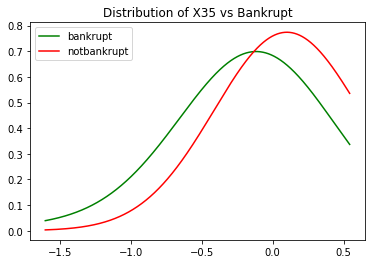

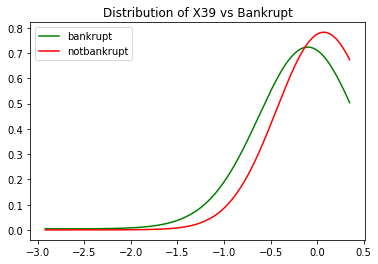

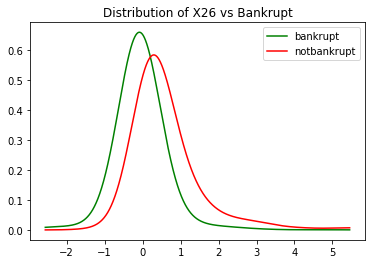

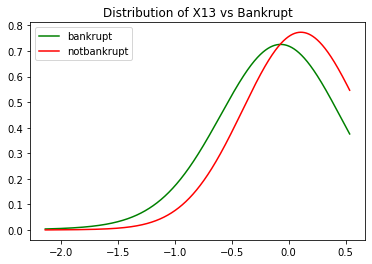

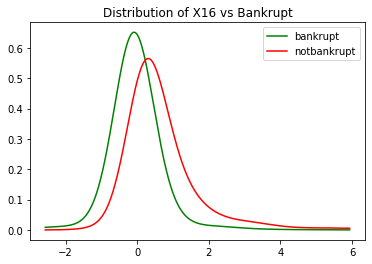

In [21]:
from utils import binary_kde_plot
for i in ['X35', 'X39', 'X26', 'X13', 'X16']:
    binary_kde_plot(train_data, i, 'Bankrupt')

At a level of 5% significance, all features shows a significant difference between F(Xi|Bankrupt = 1) and F(Xi|Bankrupt = 0). I plot the kernal density function of 5 features vs Bankrupt. The shapes of two kernal density functions are quite similar, but there are is always a drfit or a stretch on bankrupt samples compared with non-bankrupt samples.

## Feature Engineering

### Create New Features

In [22]:
# Generate financial statement data features
datasets = [train_data, test_data]
for dataset in datasets:
    dataset['X65'] = dataset['X55']/dataset['X3']
    dataset['X66'] = dataset['X1']*dataset['X65']
    dataset['X67'] = dataset['X2']*dataset['X65']
    dataset['X68'] = dataset['X7']*dataset['X65']
    dataset['X69'] = dataset['X8']*dataset['X67']
    dataset['X70'] = dataset['X9']*dataset['X65']
    dataset['X71'] = dataset['X10']*dataset['X65']
    dataset['X72'] = dataset['X18']*dataset['X65']
    dataset['X73'] = dataset['X13']*dataset['X70']-dataset['X72']
    dataset['X74'] = dataset['X14']*dataset['X70']-dataset['X72']
    dataset['X75'] = dataset['X22']*dataset['X65']
    dataset['X76'] = dataset['X55']/dataset['X28']
    dataset['X77'] = dataset['X34']*dataset['X67']
    dataset['X78'] = dataset['X77']/dataset['X33']
    dataset['X79'] = dataset['X35']*dataset['X65']
    dataset['X80'] = dataset['X20']*dataset['X70']/365
    dataset['X81'] = dataset['X48']*dataset['X65']
    dataset['X82'] = dataset['X70']/dataset['X61']
    dataset['X83'] = dataset['X54']*dataset['X76']
    dataset['X84'] = dataset['X59']*dataset['X71']
    dataset['X85'] = dataset['X46']*dataset['X78']+dataset['X80']
    dataset['X86'] = dataset['X70']- dataset['X56']*dataset['X70']

According to the defination of 64 features, all of these features are financial indicators. However, the original financial statement data are not included in features, which are also important for financial statement analysis for bankruptcy. With simple calculation of financial indicators, I add these original financial statement data into features, which may be helpful for bankruptcy prediction. The newly added features are listed: 

|                        |                   |                       |           |    |
|  ----      | ----      | -----   |-----   |-----   |
|X65| total assets       | |X66| net profit     |
|X67| total liabilities | |X68| EBIT  |
|X69| book value to equity  |   |X70| sales  |
|X71| equity |   |X72| gross profit    |
|X73| depreciation  |  |X74| interest   |
|X75| profit on operating activities   |  |X76| fixed assets|
|X77| operating expenses   |   |X78| short-term liabilities|
|X79| profit on sales |    |X80| inventory|
|X81| EBITDA |    |X82| receivables  |
|X83| constant capital |    |X84| long-term liabilities     |
|X85| current assets |    |X86| cost of products sold   |

In [23]:
# Generate more basic financial ratios as features
datasets = [train_data, test_data]
for dataset in datasets:
    dataset['X87'] = dataset['X67']/dataset['X71']
    dataset['X88'] = (dataset['X85']-dataset['X80'])/dataset['X71']
    dataset['X89'] = dataset['X66']/dataset['X71']
    dataset['X90'] = dataset['X65']/dataset['X70']
    

There are also various financial ratios which could be derived from existing features, I add several most important and basic financial ratios in financial analysis.    

|           |                 |
|     ----      |     -----            |
|X87| debit-to-equity ratio = total liabilities / equity |   
|X88| quick ratio = (current assets – inventories)/ short-term liabilities |   
|X89| return on equity = net profit/equity   |
|X90| net profit margin = net profit/sales   |

reference: https://www.readyratios.com/reference/analysis/most_important_financial_ratios.html

In [24]:
# Count the number of missing values in each feature
train_data.isnull().sum(axis=0).sort_values(ascending=False).head(5)
test_data.isnull().sum(axis=0).sort_values(ascending=False).head(5)

# Features with missing value in train and test dataset
train_data.columns.values[train_data.isnull().any()]
test_data.columns.values[test_data.isnull().any()]

#Fill missing values of 28 features with the median value in training set
feature_set = list(train_data.columns.values[train_data.isnull().any()]) + \
              list(test_data.columns.values[test_data.isnull().any()])
for i in feature_set:
    train_data[i] = train_data[i].fillna(train_data[i].median())
    test_data[i] = test_data[i].fillna(train_data[i].median())

X88    12
X85    12
X78    12
X90     1
X75     1
dtype: int64

X88    5
X85    5
X78    5
X90    1
X75    1
dtype: int64

array(['X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73',
       'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82',
       'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90'],
      dtype=object)

array(['X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73',
       'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82',
       'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90'],
      dtype=object)

Because division operator is included in feature generating process, there will generate new Nan value when denominator is zero. Thus, I impute the missing value with median again here.

In [25]:
train_data.loc[:,'X65':].describe()

,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,...,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90
count,5.575000e+03,5575.000000,5.575000e+03,5575.000000,5.575000e+03,5.575000e+03,5.575000e+03,5575.000000,5.575000e+03,5575.000000,...,5575.000000,5575.000000,5.575000e+03,5575.000000,5.575000e+03,5.575000e+03,5575.000000,5575.000000,5575.000000,5575.000000
mean,4.086696e+04,1021.565793,2.108402e+04,1426.769643,1.884309e+04,4.586323e+04,1.824872e+04,1426.769643,1.864069e+03,916.785110,...,157.540075,7616.541479,2.275421e+04,4770.352368,1.041205e+04,4.172631e+04,1.947580,0.780884,-0.333958,2.435621
std,1.384447e+05,16481.936399,7.448718e+04,18352.139186,7.638590e+04,1.624919e+05,7.744697e+04,18352.139186,2.658700e+04,10743.503275,...,17415.148683,32673.653128,9.251942e+04,31184.340445,3.573449e+04,1.482299e+05,58.865212,15.695921,19.367201,73.484238
min,-9.923554e+05,-504593.352621,-8.611259e+05,-504593.352621,-1.581945e+05,-2.844152e+06,-1.498378e+05,-504593.352621,-3.929739e+05,-88663.711270,...,-589717.283488,-672563.157334,-2.046754e+05,-200380.876188,-6.762045e+05,-3.093077e+06,-420.586989,-180.108186,-1237.649402,-12.870571
25%,1.727128e+03,-449.100144,9.630402e+02,-441.885335,2.106034e+02,3.289164e+03,1.578526e+02,-441.885335,3.905076e+00,-47.005725,...,-719.804559,347.144114,1.878899e+02,0.000000,6.752271e+02,3.290444e+03,0.174927,0.019549,-0.069053,0.511456
50%,8.371666e+03,34.438825,4.164316e+03,47.681050,2.457540e+03,1.081869e+04,2.194659e+03,47.681050,1.230452e+02,50.415909,...,-27.076486,1414.694914,2.685104e+03,20.464336,2.827384e+03,1.069356e+04,0.774761,0.295880,0.100945,0.823992
75%,2.600348e+04,1061.893260,1.442985e+04,1260.055279,1.047712e+04,3.097926e+04,1.002444e+04,1260.055279,8.881961e+02,576.673531,...,651.498175,4856.260376,1.242181e+04,1065.850115,7.646221e+03,2.946822e+04,2.079576,0.836495,0.291331,0.995533
max,2.459061e+06,341207.031395,1.433258e+06,415291.273689,1.933175e+06,3.113418e+06,1.933142e+06,415291.273689,1.173244e+06,395365.561473,...,351497.353930,754146.433371,2.073993e+06,695697.725743,1.132857e+06,3.038341e+06,3802.031873,920.177588,277.135508,5235.602094


## Modeling

In [26]:
# X, Y split in train and test dataset
features = set(train_data.columns.values)-set(['Bankrupt'])
X_train = train_data[features]
Y_train = train_data['Bankrupt']
X_test = test_data[features]
Y_test = test_data['Bankrupt']

kfold = StratifiedKFold(n_splits=5)

### Feature Importance

Feature ranking:
1. X26 (0.090642)
2. X39 (0.085026)
3. X16 (0.082463)
4. X13 (0.051093)
5. X35 (0.049563)
6. X79 (0.045861)
7. X11 (0.038667)
8. X83 (0.025100)
9. X82 (0.023245)
10. X6 (0.020291)
11. X21 (0.017039)
12. X55 (0.016227)
13. X66 (0.014647)
14. X54 (0.014299)
15. X65 (0.012573)


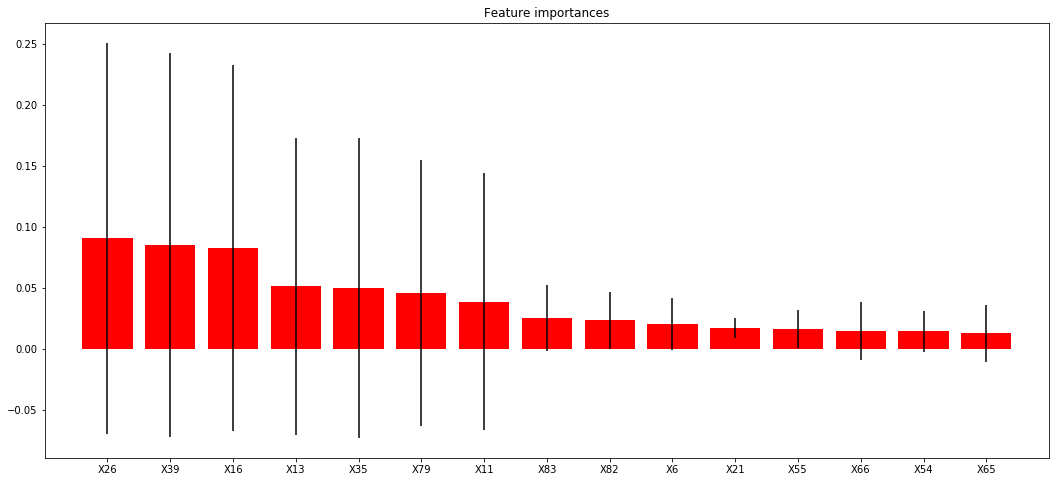

In [27]:
# Feature importance analysis with RandomForestClassifier
from utils import feature_importance_analysis
feature_importance_analysis(X_train, Y_train, 15, random_state)

As I stated before, feature importance analysis helps to figure out the problem of viewing 'Id' as a feature, because before conducting a feature importance analysis, I thought that 'Id' is assigned to samples randomly. But when I dive further, I found it was not the case, then I dropped 'Id' from features.

From the feature importance analysis, I find 5 most important features are all related with profit, which is quite reasonable from a logical point of view. If a company cannot make enough profit, it will go broke.

### Simple Modeling

In [28]:
# Compare 10 popular classifiers and evaluate the mean fbeta score of each of them by cross validation procedure.
from utils import simple_modeling
simple_modeling(X_train, Y_train, kfold, random_state)

,CrossValMeans,CrossValerrors
Algorithm,,
ExtraTrees,0.960005,0.015383
RandomForest,0.957854,0.012465
GradientBoosting,0.937769,0.028012
AdaBoost,0.925748,0.024208
DecisionTree,0.923775,0.027241
MultipleLayerPerceptron,0.903496,0.021146
KNeighboors,0.903325,0.016464
LinearDiscriminantAnalysis,0.838761,0.036206
LogisticRegression,0.822074,0.027844


In order to address the issue of different importance of each type of misclassification, I take fbeta score as scorer in cross validation evaluation and test dataset evaluation. 

$$
F _ { \beta } = \left( 1 + \beta ^ { 2 } \right) \frac { P \cdot R } { \beta ^ { 2 } \cdot P + R }
$$

$$
P = \frac { T P } { T P + F P }
$$

$$
R = \frac { T P } { T P + F N }
$$

When we take R and P into $F_{ \beta}$, we can get

$$
F _ { \beta } = \frac { 1 } { 1 + \frac { \beta ^ { 2 } F N + F P } { \left( 1 + \beta ^ { 2 } \right) T P } }
$$

Because it is 5 times worse to misclassify a company that does go bankrupt than to misclassify a company that does not go bankrupt, $\beta ^ { 2 }$ should be 5.

Based on the results of simple modeling, I choose ExtraTrees, GradientBoosting, MultipleLayerPerceptron and RandomForest for hyperparameter tunning with grid search.

### Hyperparameter Tunning for Best Models

In [29]:
models = {}

LR = LogisticRegression(random_state = random_state)
RFC = RandomForestClassifier(random_state = random_state)
GBC = GradientBoostingClassifier(random_state = random_state)
MLP = MLPClassifier(random_state = random_state)
ETC = ExtraTreesClassifier(random_state=random_state)

models[LR] = {"penalty": ['l1','l2'],
              "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
              "class_weight": [None,'balanced']}

models[RFC] = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

models[GBC] = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}

models[MLP] = {"hidden_layer_sizes": [(50,),(100,),(200,),(300,),(400,),(500,)],
              "activation": ['identity', 'logistic', 'tanh', 'relu']}

models[ETC] = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300]}

In [30]:
from utils import gridSearch
best_model, best_score = gridSearch(models, X_train, Y_train, 'fbeta', kfold)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed: 10.3min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  6.4min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  5.5min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  4.8min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.3min finished


There are 5 types of model in models, best_model contains the best model among each type and best_score contains the best score among each type. The best model of all would be selected from best_model. 

The best model is GradientBoostingClassifier, with learning_rate=0.1, max_depth=8, max_features=0.3, min_samples_leaf=100 and n_estimators=300.

In [31]:
cross_val_score = max(best_score)
model = best_model[best_score.index(max(best_score))]
Y_train_predict = model.predict(X_train)

print("Average Cross Validation Score = {a:.2%}".format(a=cross_val_score) )

Average Cross Validation Score = 98.08%


## Error Analysis

<Figure size 432x288 with 0 Axes>

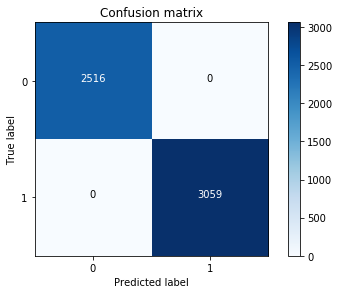

In [32]:
from utils import plot_confusion_matrix
matrix = confusion_matrix(Y_train,Y_train_predict)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(matrix, classes=class_names, title='Confusion matrix')
plt.show()

The prediction on the train dataset is quite good, actually we should evaluate the model on the test dataset. 

Conventionally, the Confusion Matrix on the test data set should have much more FP (True label: negative, Predicted label: positive) than FN (True label: positive, Predicted label: negative), because I choose a fbeata (beta = 5) as a criterion to select model and tune hyper parameters, which lead us to achieve the requirement. 

We can also calculate the accuracy, recall and precision from Confusion Matrix.For test dataset result, Precision is quite low precision and recall is relatively much higher,because we choose beta > 1, which means we will focus more on recall.

## Submission

In [34]:
from utils import myModel
# the test dataset file should be in ./data, model is the best model selected from previous work
myModel('test.csv', model)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X82,X83,X84,X85,X86,X87,X88,X89,X90,Predict
Id,,,,,,,,,,,,,,,,,,,,,
5657,0.500000,0.908510,0.049738,1.11680,-22.1520,-0.473550,0.503030,0.100770,1.946500,0.091550,...,1607.967068,2593.492490,1929.031095,2769.730542,10643.853977,9.923648,2.776580,5.461496,0.513743,1.0
5835,-0.093794,0.663230,-0.005587,0.99150,-66.7160,-0.050834,-0.093794,0.507760,1.494200,0.336770,...,3312.099296,3073.955619,0.000000,5062.156233,14396.592395,1.969386,0.857812,-0.278511,0.669254,1.0
5782,0.024089,0.584230,-0.014468,0.94588,-10.6790,0.024089,0.025381,0.555310,1.009800,0.324430,...,7307.122564,53593.339186,26481.614447,2079.040760,83563.042676,1.800789,0.012235,0.074250,0.990295,1.0
3671,0.086352,0.234020,0.709400,4.03130,13.5150,0.179460,0.108490,3.136300,1.029100,0.733970,...,2028.612873,13456.199713,0.000000,2232.615539,18334.220849,0.318841,0.023791,0.117651,0.971723,0.0
5873,0.016964,0.755030,0.081574,1.12680,-197.0700,0.002708,0.016964,0.324450,0.887900,0.244970,...,48436.766831,66151.808840,1807.591804,190420.287721,185980.646188,3.082133,2.554992,0.069249,1.126253,1.0
218,-0.039181,0.771080,0.276400,1.97740,8.8620,-0.199050,-0.041620,0.244530,1.002500,0.188550,...,1371.066889,6495.207273,4685.907850,1040.371786,9595.869513,4.089525,-0.002161,-0.207802,0.997506,0.0
5726,0.218720,0.788130,0.190880,1.24220,10.2590,-0.067590,0.327380,0.268830,7.069700,0.211870,...,1508.558018,348.842551,0.000000,1611.979523,11100.961341,3.719875,4.620829,1.032331,0.141449,1.0
5893,-0.089739,1.330000,-0.314680,0.67454,-124.5300,-1.260700,-0.089739,-0.247990,2.232700,-0.329810,...,1010.970906,-1319.632698,990.353275,6720.907116,12192.713114,-4.032625,-1.539826,0.272093,0.447888,1.0
62,0.037841,0.167040,0.307110,2.84580,37.3060,0.151900,0.050671,4.570600,1.029600,0.763480,...,1324.771623,9860.622300,8.423525,1337.403378,12903.786228,0.218788,0.011075,0.049564,0.971251,0.0


In [35]:
print('Done')

Done
